In [1]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Embedding, Flatten
from tensorflow.keras.optimizers import Adam


In [2]:
  #Connect to google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
merged_df = pd.read_csv('/content/drive/MyDrive/Masters/Dissertation/13-08-24/merged_data_SPX 500.csv')
merged_df.tail()

,Date,Open,High,Low,Close,Volume,Mid,SMA50,SMA100,SMA150,...,OBV,BollingerUp_mid,BollingerDown_mid,RSI,macd,macd_h,macd_s,%K,%D,Capped Sentiment
2299,2024-08-06,5206.419922,5312.339844,5193.560059,5240.029785,4.690190e+09,5223.224853,5446.987798,5309.117097,5187.315464,...,5.103422e+11,5681.930695,5212.044901,28.980956,-46.930240,-41.094241,-5.835999,24.408337,16.616250,-0.01200
2300,2024-08-07,5293.129883,5330.640137,5195.540039,5199.500000,4.558260e+09,5246.314941,5446.052393,5309.952146,5190.664129,...,5.057840e+11,5683.851374,5208.253411,32.078590,-55.733148,-39.917719,-15.815429,17.215976,18.317421,0.00851
2301,2024-08-08,5252.569824,5328.029785,5233.850098,5319.310059,4.016830e+09,5285.939942,5445.551689,5311.609546,5194.470796,...,5.098008e+11,5684.613622,5206.489757,37.293747,-58.833909,-34.414784,-24.419125,42.921872,28.182061,0.05004
2302,2024-08-09,5314.660156,5358.669922,5300.839844,5344.160156,3.516400e+09,5329.410156,5446.683091,5313.382698,5198.713197,...,5.133172e+11,5682.927602,5210.438579,42.660308,-57.125098,-26.164779,-30.960319,48.253594,36.130481,-0.00573
2303,2024-08-12,5351.879883,5371.200195,5324.370117,5344.390137,3.360160e+09,5348.135010,5448.693291,5315.276050,5203.074730,...,5.166773e+11,5679.676293,5217.710289,44.916574,-53.641568,-18.144999,-35.496569,50.375962,47.183809,0.07521


In [4]:
merged_df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Mid', 'SMA50',
       'SMA100', 'SMA150', 'SMA200', 'EMA10', 'ATR', 'OBV', 'BollingerUp_mid',
       'BollingerDown_mid', 'RSI', 'macd', 'macd_h', 'macd_s', '%K', '%D',
       'Capped Sentiment'],
      dtype='object')

# Preparation for Machine Learning

In [5]:
# Calculate lagging sentiment features
merged_df['Sentiment Lag 1'] = merged_df['Capped Sentiment'].shift(5)
merged_df['Sentiment Lag 2'] = merged_df['Capped Sentiment'].shift(10)
merged_df['Sentiment MA 3'] = merged_df['Capped Sentiment'].rolling(window=3).mean()
merged_df['Sentiment MA 5'] = merged_df['Capped Sentiment'].rolling(window=5).mean()

# Add overnight sentiment (shifting sentiment to predict next day's open)
merged_df['Overnight Sentiment'] = merged_df['Capped Sentiment'].shift(-1)


# Prepare historical data for training
historical_data = merged_df.copy()
historical_data['Tomorrow Open'] = historical_data['Open'].shift(-1)
historical_data['Tomorrow Close'] = historical_data['Close'].shift(-1)

for lag in range(1, 8):
    historical_data[f'Open_Lag_{lag}'] = historical_data['Open'].shift(lag)
    historical_data[f'Close_Lag_{lag}'] = historical_data['Close'].shift(lag)
    historical_data[f'High_Lag_{lag}'] = historical_data['High'].shift(lag)
    historical_data[f'Low_Lag_{lag}'] = historical_data['Low'].shift(lag)
    historical_data[f'Volume_Lag_{lag}'] = historical_data['Volume'].shift(lag)

for window in [3, 5, 10]:
    historical_data[f'Open_MA_{window}'] = historical_data['Open'].rolling(window=window).mean()
    historical_data[f'Close_MA_{window}'] = historical_data['Close'].rolling(window=window).mean()
    historical_data[f'High_MA_{window}'] = historical_data['High'].rolling(window=window).mean()
    historical_data[f'Low_MA_{window}'] = historical_data['Low'].rolling(window=window).mean()
    historical_data[f'Volume_MA_{window}'] = historical_data['Volume'].rolling(window=window).mean()

historical_data['Open_Close_Diff'] = historical_data['Open'] - historical_data['Close']
historical_data['High_Low_Diff'] = historical_data['High'] - historical_data['Low']
for window in [3, 5, 10]:
    historical_data[f'Volatility_{window}'] = historical_data['High'].rolling(window=window).max() - historical_data['Low'].rolling(window=window).min()

historical_data['Williams_R'] = (historical_data['High'].rolling(window=14).max() - historical_data['Close']) / (historical_data['High'].rolling(window=14).max() - historical_data['Low'].rolling(window=14).min())

historical_data['Uptrend'] = (historical_data['Close'] > historical_data['Close'].shift(1)).astype(int)
historical_data['Downtrend'] = (historical_data['Close'] < historical_data['Close'].shift(1)).astype(int)


In [6]:
# Handle NaN values by forward filling and then backward filling
historical_data.ffill(inplace=True)
historical_data.bfill(inplace=True)

In [7]:
# Convert 'Date' column in to datetime format
historical_data['Date'] = pd.to_datetime(historical_data['Date'])
historical_data.set_index('Date', inplace=True)

In [8]:
historical_data.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Mid', 'SMA50', 'SMA100',
       'SMA150', 'SMA200', 'EMA10', 'ATR', 'OBV', 'BollingerUp_mid',
       'BollingerDown_mid', 'RSI', 'macd', 'macd_h', 'macd_s', '%K', '%D',
       'Capped Sentiment', 'Sentiment Lag 1', 'Sentiment Lag 2',
       'Sentiment MA 3', 'Sentiment MA 5', 'Overnight Sentiment',
       'Tomorrow Open', 'Tomorrow Close', 'Open_Lag_1', 'Close_Lag_1',
       'High_Lag_1', 'Low_Lag_1', 'Volume_Lag_1', 'Open_Lag_2', 'Close_Lag_2',
       'High_Lag_2', 'Low_Lag_2', 'Volume_Lag_2', 'Open_Lag_3', 'Close_Lag_3',
       'High_Lag_3', 'Low_Lag_3', 'Volume_Lag_3', 'Open_Lag_4', 'Close_Lag_4',
       'High_Lag_4', 'Low_Lag_4', 'Volume_Lag_4', 'Open_Lag_5', 'Close_Lag_5',
       'High_Lag_5', 'Low_Lag_5', 'Volume_Lag_5', 'Open_Lag_6', 'Close_Lag_6',
       'High_Lag_6', 'Low_Lag_6', 'Volume_Lag_6', 'Open_Lag_7', 'Close_Lag_7',
       'High_Lag_7', 'Low_Lag_7', 'Volume_Lag_7', 'Open_MA_3', 'Close_MA_3',
       'High_MA_3', 'Low_MA_

In [9]:
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Mid', 'SMA50', 'SMA100',
       'SMA150', 'SMA200', 'EMA10', 'ATR', 'OBV', 'BollingerUp_mid',
       'BollingerDown_mid', 'RSI', 'macd', 'macd_h', 'macd_s', '%K', '%D',
       'Capped Sentiment', 'Sentiment Lag 1', 'Sentiment Lag 2',
       'Sentiment MA 3', 'Sentiment MA 5', 'Overnight Sentiment',
        'Open_Lag_1', 'Close_Lag_1',
       'High_Lag_1', 'Low_Lag_1', 'Volume_Lag_1', 'Open_Lag_2', 'Close_Lag_2',
       'High_Lag_2', 'Low_Lag_2', 'Volume_Lag_2', 'Open_Lag_3', 'Close_Lag_3',
       'High_Lag_3', 'Low_Lag_3', 'Volume_Lag_3', 'Open_Lag_4', 'Close_Lag_4',
       'High_Lag_4', 'Low_Lag_4', 'Volume_Lag_4', 'Open_Lag_5', 'Close_Lag_5',
       'High_Lag_5', 'Low_Lag_5', 'Volume_Lag_5', 'Open_Lag_6', 'Close_Lag_6',
       'High_Lag_6', 'Low_Lag_6', 'Volume_Lag_6', 'Open_Lag_7', 'Close_Lag_7',
       'High_Lag_7', 'Low_Lag_7', 'Volume_Lag_7', 'Open_MA_3', 'Close_MA_3',
       'High_MA_3', 'Low_MA_3', 'Volume_MA_3', 'Open_MA_5', 'Close_MA_5',
       'High_MA_5', 'Low_MA_5', 'Volume_MA_5', 'Open_MA_10', 'Close_MA_10',
       'High_MA_10', 'Low_MA_10', 'Volume_MA_10', 'Open_Close_Diff',
       'High_Low_Diff', 'Volatility_3', 'Volatility_5', 'Volatility_10',
       'Williams_R', 'Uptrend', 'Downtrend']

X = historical_data[features]

In [10]:
# Create classification targets
historical_data['Price Direction Open'] = (historical_data['Tomorrow Open'] > historical_data['Close']).astype(int)
historical_data['Price Direction Close'] = (historical_data['Tomorrow Close'] > historical_data['Tomorrow Open']).astype(int)

X = historical_data[features]
y_open = historical_data['Price Direction Open']
y_close = historical_data['Price Direction Close']

In [11]:
# Apply standardization to the dataset
scaler_standard = StandardScaler()
X_standardized = scaler_standard.fit_transform(X)

# Split the data into training and testing sets for standardized data
X_train_std_open, X_test_std_open, y_train_std_open, y_test_std_open = train_test_split(X_standardized, y_open, test_size=0.2, random_state=4)
X_train_std_close, X_test_std_close, y_train_std_close, y_test_std_close = train_test_split(X_standardized, y_close, test_size=0.2, random_state=4)

In [12]:
def confusion_matrixtask(y_true, y_pred):
# Generate a confusion matrix
  cm = confusion_matrix(y_true, y_pred)

# Define the color map
  cmap = plt.get_cmap('Blues')

# Plot the confusion matrix as a heat map
  sns.heatmap(cm, cmap=cmap, annot=True, fmt='g')
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.show()

def classification_reportTask(y_true, y_pred):
  # Generate a classification report
  cr = classification_report(y_true, y_pred, output_dict=True)

# Convert the report to a data frame
  df = pd.DataFrame(cr).transpose()

# Define the color map
  cmap = plt.get_cmap('Blues')
  cmap1 = plt.get_cmap('Accent')

# Plot the data frame as a heat map
  sns.heatmap(df.iloc[:-1, :-1], cmap=cmap, annot=True, fmt='.2f')
  plt.xlabel('Predicted label')
  plt.ylabel('True label')
  plt.show()
  sns.heatmap(df.iloc[:-1, 3:4], cmap=cmap1, annot=True, fmt='.2f')
  plt.xlabel('Predicted label')
  plt.ylabel('True label')
  plt.show()

--- Logistic Regression for Tomorrow Open ---
Best Parameters: {'C': 0.1, 'max_iter': 100, 'solver': 'lbfgs'}
Accuracy: 0.5856832971800434
Precision: 0.5915119363395226
Recall: 0.8576923076923076
F1 Score: 0.7001569858712716
ROC AUC: 0.545761576731726


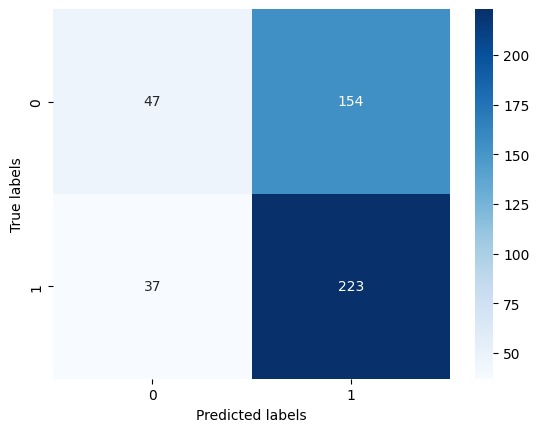

Confusion Matrix: 
None



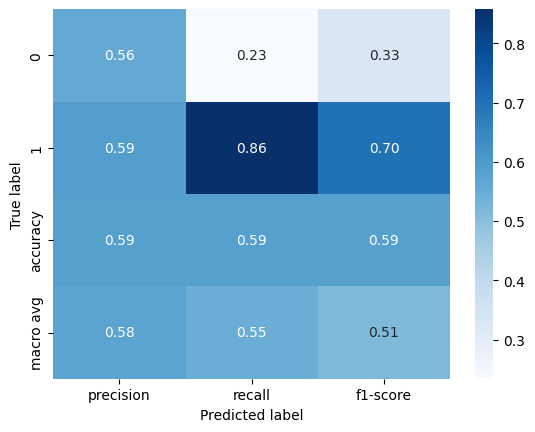

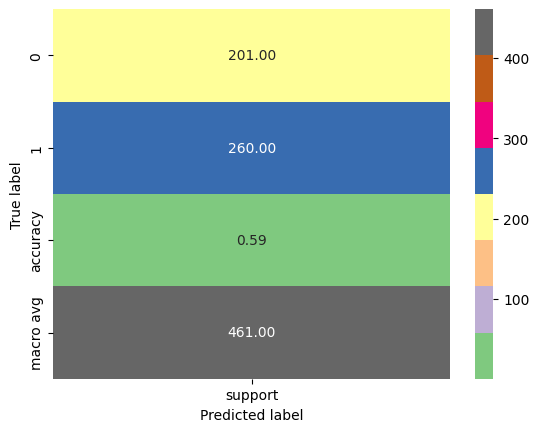

Classification Report: 
None

--- SVM for Tomorrow Open ---
Best Parameters: {'C': 0.1, 'kernel': 'linear'}
Accuracy: 0.5856832971800434
Precision: 0.5851851851851851
Recall: 0.9115384615384615
F1 Score: 0.712781954887218
ROC AUC: 0.5378587830080367


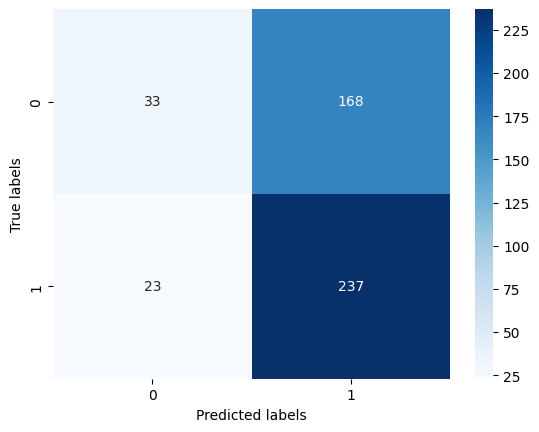

Confusion Matrix: 
None



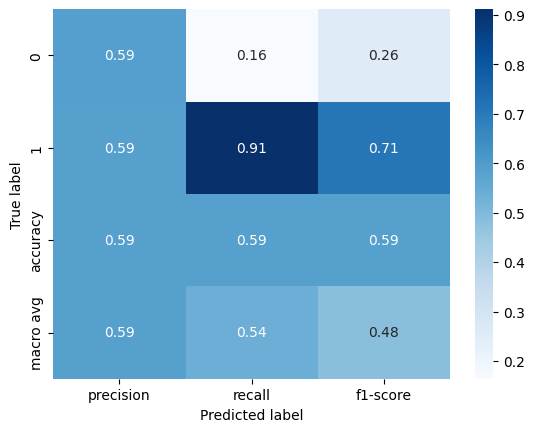

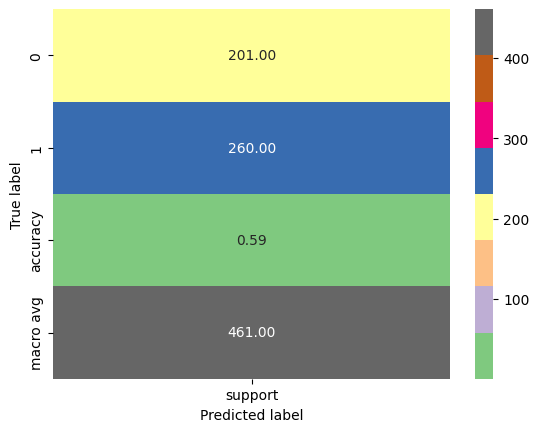

Classification Report: 
None

--- Decision Tree for Tomorrow Open ---
Best Parameters: {'max_depth': 20, 'min_samples_split': 10}
Accuracy: 0.4772234273318872
Precision: 0.5372549019607843
Recall: 0.5269230769230769
F1 Score: 0.5320388349514563
ROC AUC: 0.4699292001530807


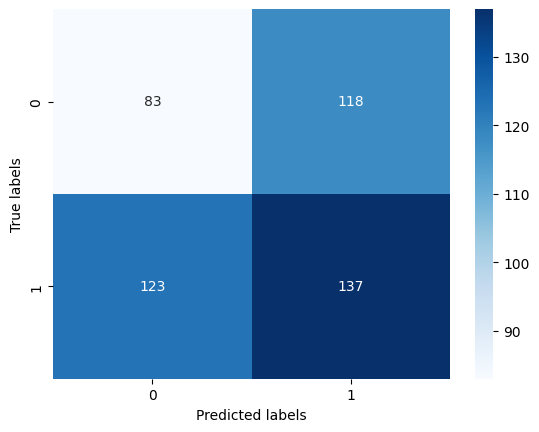

Confusion Matrix: 
None



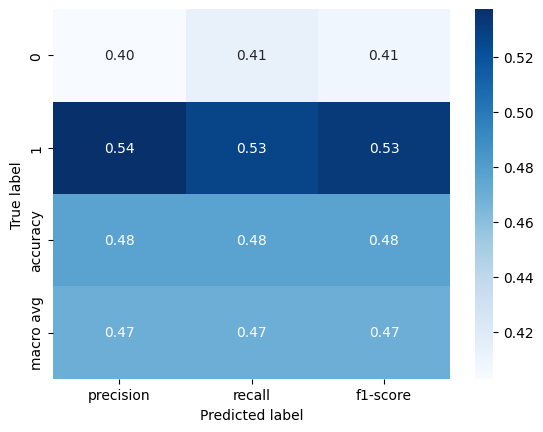

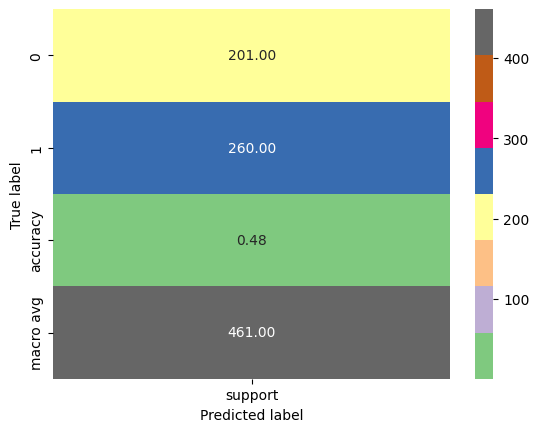

Classification Report: 
None

--- Random Forest for Tomorrow Open ---
Best Parameters: {'max_depth': 10, 'n_estimators': 50}
Accuracy: 0.544468546637744
Precision: 0.5686813186813187
Recall: 0.7961538461538461
F1 Score: 0.6634615384615383
ROC AUC: 0.507529659395331


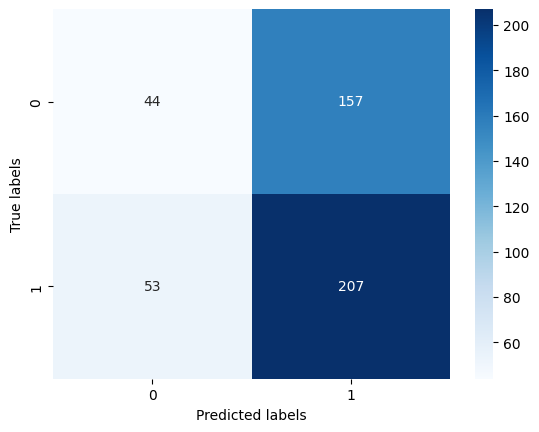

Confusion Matrix: 
None



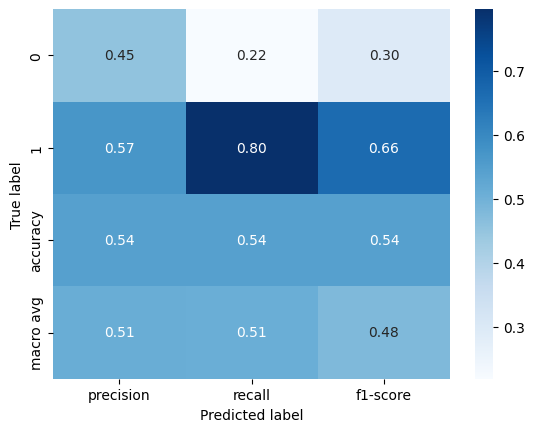

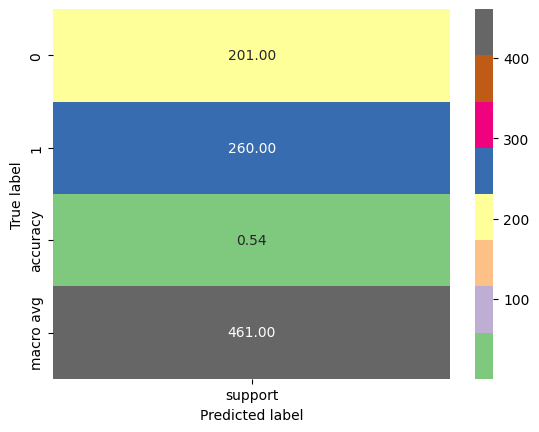

Classification Report: 
None

--- KNN for Tomorrow Open ---
Best Parameters: {'n_neighbors': 9, 'weights': 'uniform'}
Accuracy: 0.5184381778741866
Precision: 0.5683453237410072
Recall: 0.6076923076923076
F1 Score: 0.587360594795539
ROC AUC: 0.5053386911595867


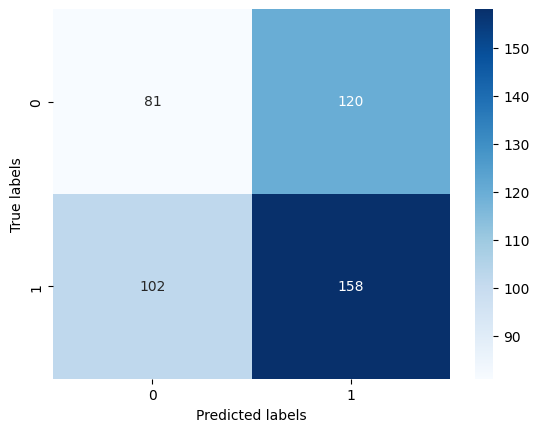

Confusion Matrix: 
None



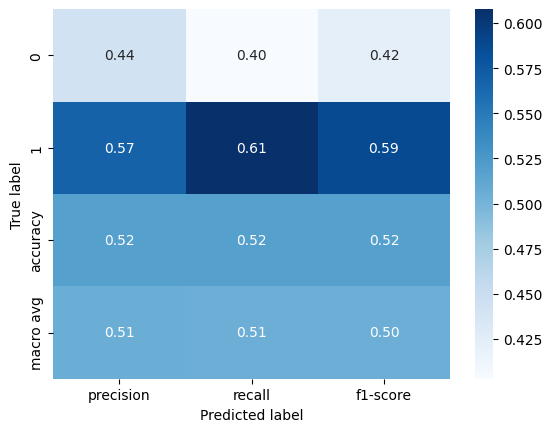

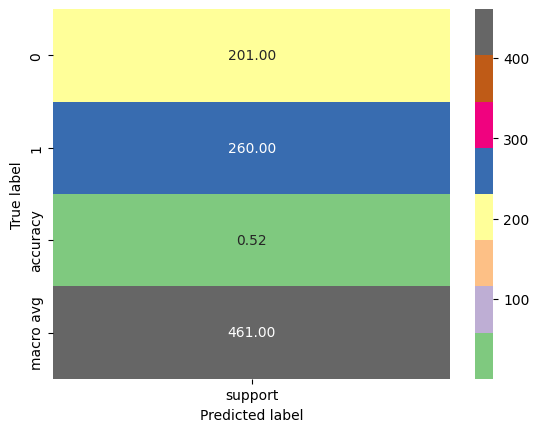

Classification Report: 
None

--- Naive Bayes for Tomorrow Open ---
Best Parameters: {}
Accuracy: 0.4880694143167028
Precision: 0.5588235294117647
Recall: 0.43846153846153846
F1 Score: 0.4913793103448276
ROC AUC: 0.4953501722158439


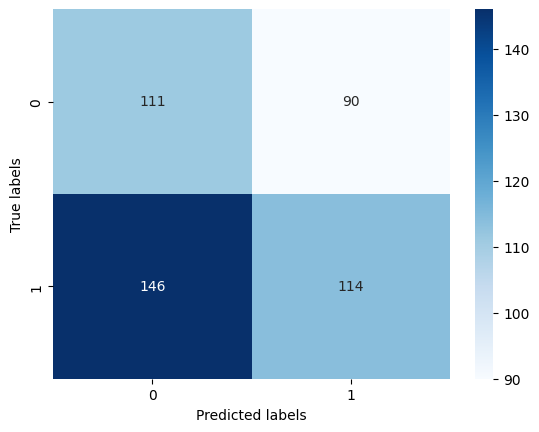

Confusion Matrix: 
None



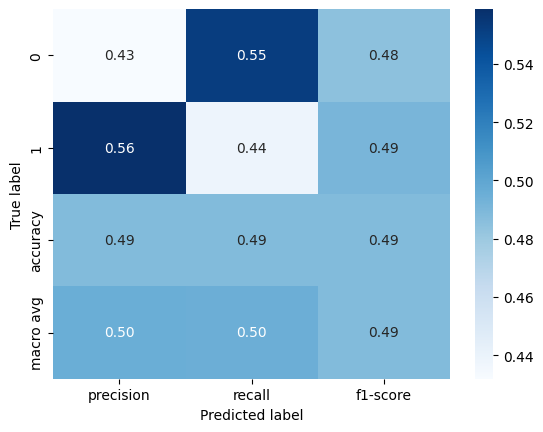

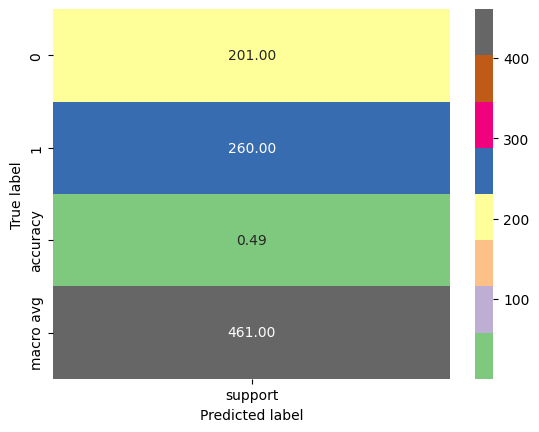

Classification Report: 
None

--- Logistic Regression for Tomorrow Close ---
Best Parameters: {'C': 0.1, 'max_iter': 100, 'solver': 'lbfgs'}
Accuracy: 0.5140997830802603
Precision: 0.5290102389078498
Recall: 0.6431535269709544
F1 Score: 0.5805243445692884
ROC AUC: 0.5079403998491135


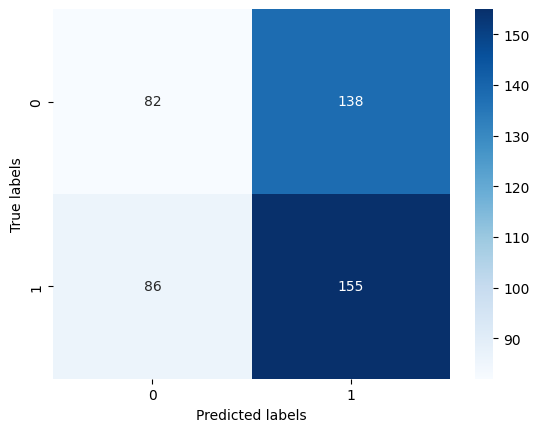

Confusion Matrix: 
None



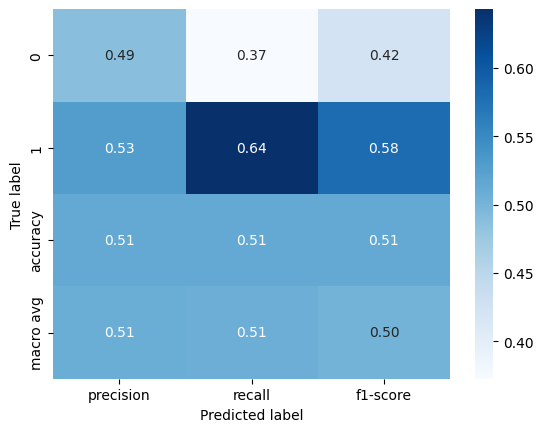

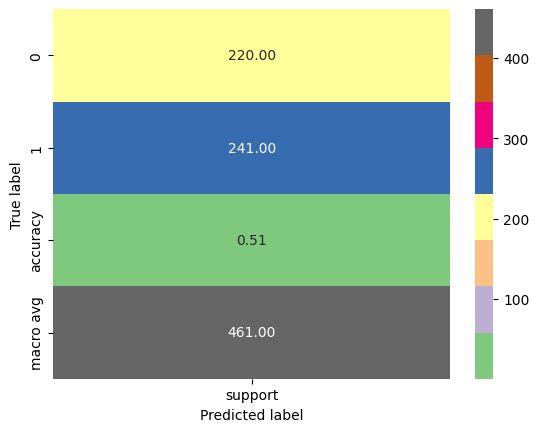

Classification Report: 
None

--- SVM for Tomorrow Close ---
Best Parameters: {'C': 1, 'kernel': 'rbf'}
Accuracy: 0.5509761388286334
Precision: 0.55
Recall: 0.7759336099585062
F1 Score: 0.6437177280550774
ROC AUC: 0.5402395322519804


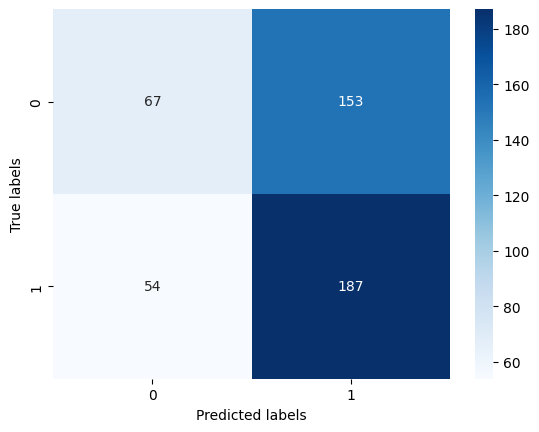

Confusion Matrix: 
None



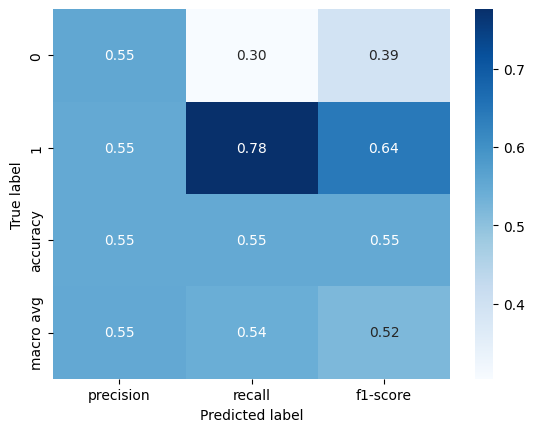

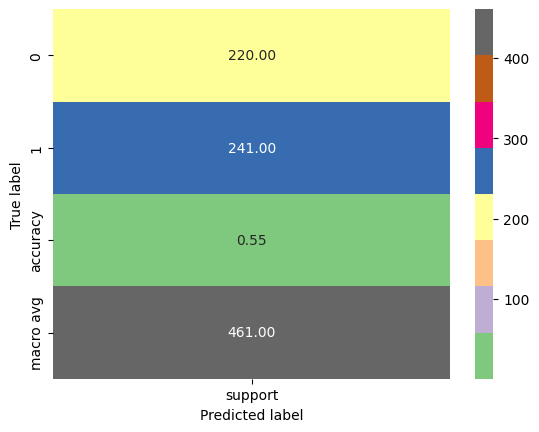

Classification Report: 
None

--- Decision Tree for Tomorrow Close ---
Best Parameters: {'max_depth': None, 'min_samples_split': 2}
Accuracy: 0.4967462039045553
Precision: 0.519650655021834
Recall: 0.49377593360995853
F1 Score: 0.5063829787234042
ROC AUC: 0.49688796680497926


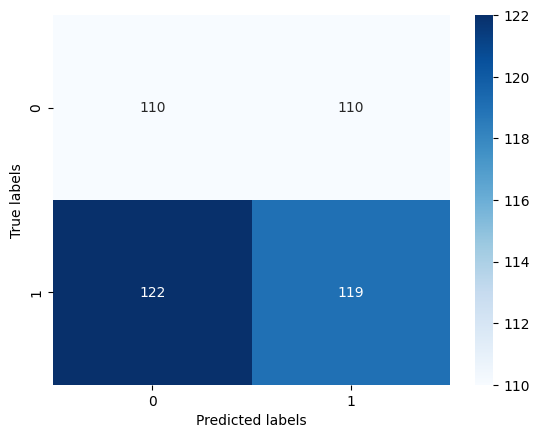

Confusion Matrix: 
None



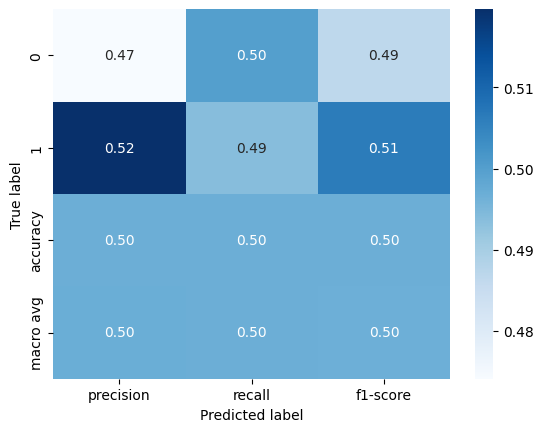

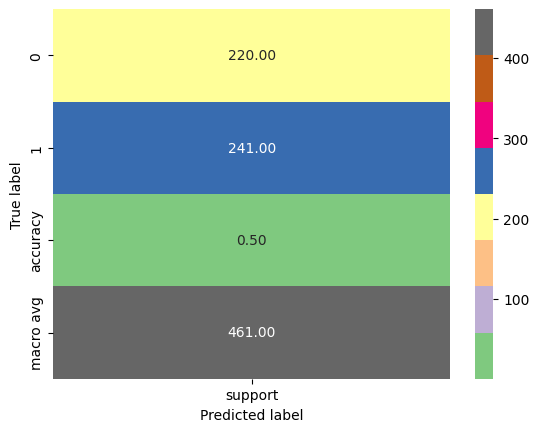

Classification Report: 
None

--- Random Forest for Tomorrow Close ---
Best Parameters: {'max_depth': 10, 'n_estimators': 100}
Accuracy: 0.5032537960954447
Precision: 0.5193548387096775
Recall: 0.6680497925311203
F1 Score: 0.5843920145190562
ROC AUC: 0.49538853262919647


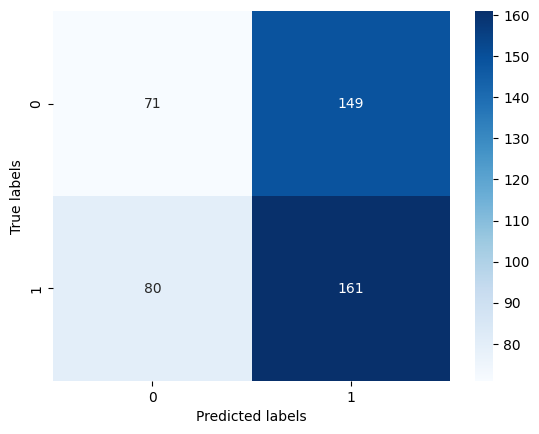

Confusion Matrix: 
None



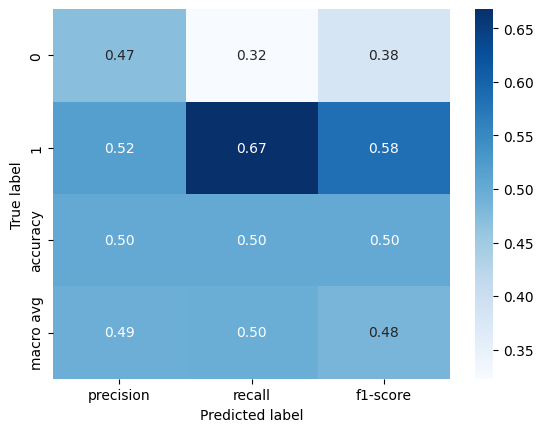

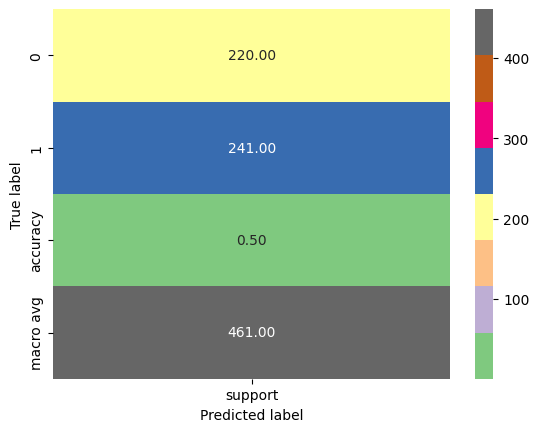

Classification Report: 
None

--- KNN for Tomorrow Close ---
Best Parameters: {'n_neighbors': 9, 'weights': 'uniform'}
Accuracy: 0.48156182212581344
Precision: 0.5037037037037037
Recall: 0.5643153526970954
F1 Score: 0.532289628180039
ROC AUC: 0.47761222180309315


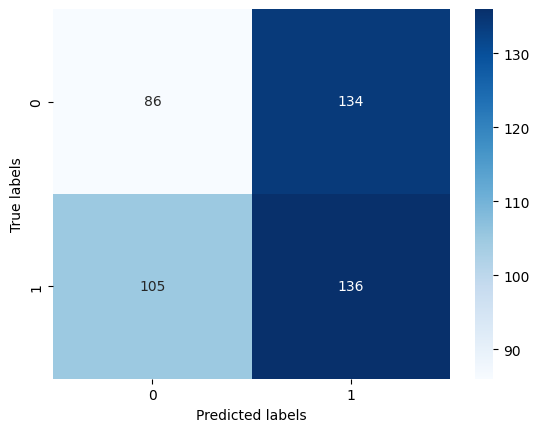

Confusion Matrix: 
None



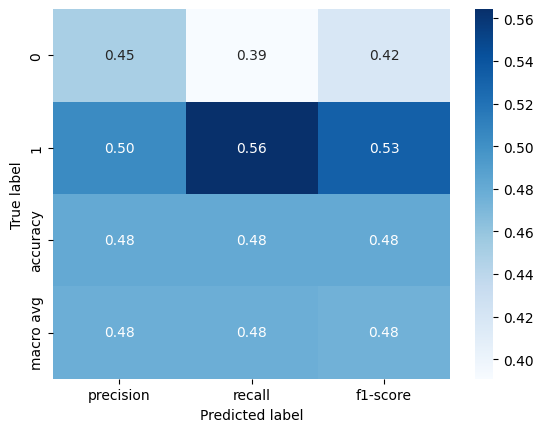

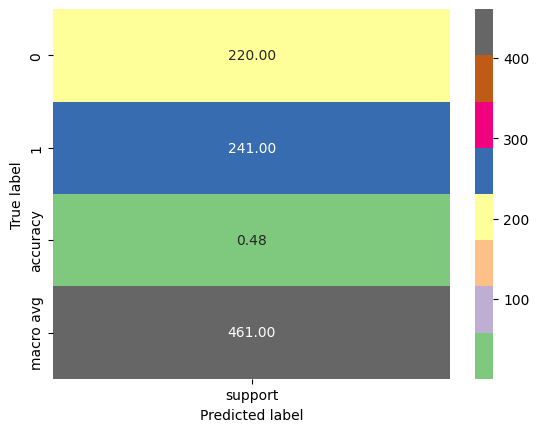

Classification Report: 
None

--- Naive Bayes for Tomorrow Close ---
Best Parameters: {}
Accuracy: 0.48590021691973967
Precision: 0.5089285714285714
Recall: 0.4730290456431535
F1 Score: 0.49032258064516127
ROC AUC: 0.4865145228215768


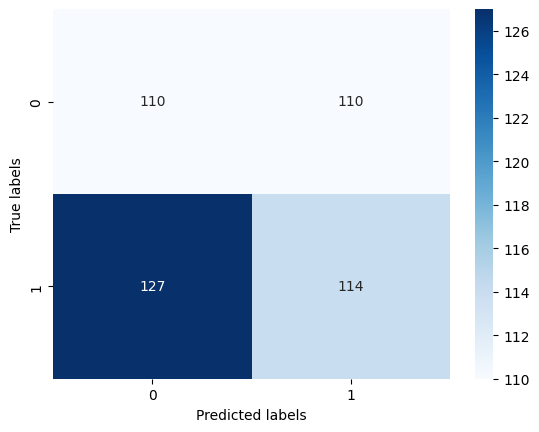

Confusion Matrix: 
None



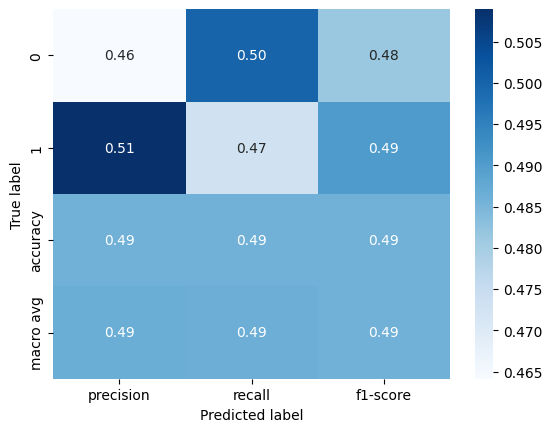

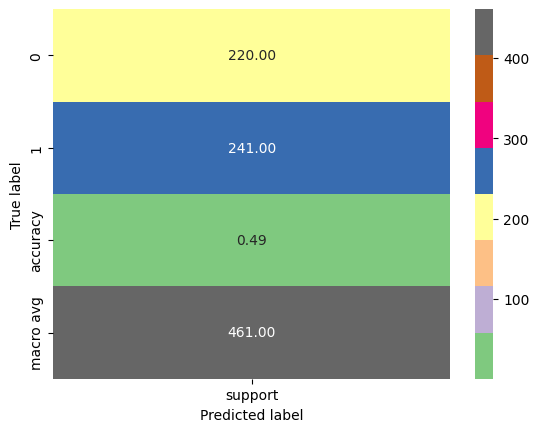

Classification Report: 
None



In [13]:
# Define parameter grids for each classifier
param_grids = {
    'Logistic Regression': {'C': [0.1, 1, 10, 100], 'solver': ['lbfgs', 'liblinear'], 'max_iter': [100, 200, 500]},
    'SVM': {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf']},
    'Decision Tree': {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]},
    'Random Forest': {'n_estimators': [10, 50, 100], 'max_depth': [None, 10, 20]},
    'KNN': {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']},
    'Naive Bayes': {}
}

# Initialize classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'SVM': svm.SVC(probability=True),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB()
}

best_classifiers = {}

# Train and evaluate each classifier for 'Tomorrow Open'
for name, classifier in classifiers.items():
    grid_search = GridSearchCV(classifier, param_grids[name], cv=5, scoring='accuracy')
    grid_search.fit(X_train_std_open, y_train_std_open)
    best_classifiers[name] = grid_search.best_estimator_
    y_pred_open = best_classifiers[name].predict(X_test_std_open)

    print(f'--- {name} for Tomorrow Open ---')
    print(f'Best Parameters: {grid_search.best_params_}')
    print(f'Accuracy: {accuracy_score(y_test_std_open, y_pred_open)}')
    print(f'Precision: {precision_score(y_test_std_open, y_pred_open)}')
    print(f'Recall: {recall_score(y_test_std_open, y_pred_open)}')
    print(f'F1 Score: {f1_score(y_test_std_open, y_pred_open)}')
    print(f'ROC AUC: {roc_auc_score(y_test_std_open, y_pred_open)}')
    print(f'Confusion Matrix: \n{confusion_matrixtask(y_test_std_open, y_pred_open)}\n')
    print(f'Classification Report: \n{classification_reportTask(y_test_std_open, y_pred_open)}\n')

# Train and evaluate each classifier for 'Tomorrow Close'
for name, classifier in classifiers.items():
    grid_search = GridSearchCV(classifier, param_grids[name], cv=5, scoring='accuracy')
    grid_search.fit(X_train_std_close, y_train_std_close)
    best_classifiers[name] = grid_search.best_estimator_
    y_pred_close = best_classifiers[name].predict(X_test_std_close)

    print(f'--- {name} for Tomorrow Close ---')
    print(f'Best Parameters: {grid_search.best_params_}')
    print(f'Accuracy: {accuracy_score(y_test_std_close, y_pred_close)}')
    print(f'Precision: {precision_score(y_test_std_close, y_pred_close)}')
    print(f'Recall: {recall_score(y_test_std_close, y_pred_close)}')
    print(f'F1 Score: {f1_score(y_test_std_close, y_pred_close)}')
    print(f'ROC AUC: {roc_auc_score(y_test_std_close, y_pred_close)}')
    print(f'Confusion Matrix: \n{confusion_matrixtask(y_test_std_close, y_pred_close)}\n')
    print(f'Classification Report: \n{classification_reportTask(y_test_std_close, y_pred_close)}\n')


In [14]:
# Predict the price direction for a new sample using the best Logistic Regression model
new_sample = pd.DataFrame({
    'Open': [0],
    'High': [0],
    'Low': [0],
    'Close': [0],
    'Volume': [0],
    'Mid': [0],
    'SMA50': [0],
    'SMA100': [0],
    'SMA150': [0],
    'SMA200': [0],
    'EMA10': [0],
    'ATR': [0],
    'OBV': [0],
    'BollingerUp_mid': [0],
    'BollingerDown_mid': [0],
    'RSI': [0],
    'macd': [0],
    'macd_h': [0],
    'macd_s': [0],
    '%K': [0],
    '%D': [0],
    'Capped Sentiment': [0],
    'Sentiment Lag 1': [0],
    'Sentiment Lag 2': [0],
    'Sentiment MA 3': [0],
    'Sentiment MA 5': [0],
   # 'Sentiment_10_Day_Sum': [historical_data['Capped Sentiment'].iloc[-10:].sum()],
    'Overnight Sentiment': [0],
    'Open_Lag_1' : [0], 'Close_Lag_1': [0],
       'High_Lag_1': [0], 'Low_Lag_1': [0], 'Volume_Lag_1': [0], 'Open_Lag_2': [0], 'Close_Lag_2': [0],
       'High_Lag_2': [0], 'Low_Lag_2': [0], 'Volume_Lag_2': [0], 'Open_Lag_3': [0], 'Close_Lag_3': [0],
       'High_Lag_3': [0], 'Low_Lag_3': [0], 'Volume_Lag_3': [0], 'Open_Lag_4': [0], 'Close_Lag_4': [0],
       'High_Lag_4': [0], 'Low_Lag_4': [0], 'Volume_Lag_4': [0], 'Open_Lag_5': [0], 'Close_Lag_5': [0],
       'High_Lag_5': [0], 'Low_Lag_5': [0], 'Volume_Lag_5': [0], 'Open_Lag_6': [0], 'Close_Lag_6': [0],
       'High_Lag_6': [0], 'Low_Lag_6': [0], 'Volume_Lag_6': [0], 'Open_Lag_7': [0], 'Close_Lag_7': [0],
       'High_Lag_7': [0], 'Low_Lag_7': [0], 'Volume_Lag_7': [0], 'Open_MA_3': [0], 'Close_MA_3': [0],
       'High_MA_3': [0], 'Low_MA_3': [0], 'Volume_MA_3': [0], 'Open_MA_5': [0], 'Close_MA_5': [0],
       'High_MA_5': [0], 'Low_MA_5': [0], 'Volume_MA_5': [0], 'Open_MA_10': [0], 'Close_MA_10': [0],
       'High_MA_10': [0], 'Low_MA_10': [0], 'Volume_MA_10': [0], 'Open_Close_Diff': [0],
       'High_Low_Diff': [0], 'Volatility_3': [0], 'Volatility_5': [0], 'Volatility_10': [0],
       'Williams_R': [0], 'Uptrend': [0], 'Downtrend': [0]})

new_sample_standardized = scaler_standard.transform(new_sample)

price_direction_open = best_classifiers['SVM'].predict(new_sample_standardized)[0]
price_direction_close = best_classifiers['Random Forest'].predict(new_sample_standardized)[0]


# Get the date for which the prediction is made
prediction_date = historical_data.index[-1] + pd.Timedelta(days=1)

print(f'Prediction for {prediction_date.date()}:')
print(f'Prediction open : {price_direction_open}')
print(f'Prediction close : {price_direction_close}')

# Print the consolidated result
if price_direction_open == 1 and price_direction_close == 1:
    print("Price will go up.")
elif price_direction_open == 0 and price_direction_close == 1:
    print("Price will go up.")
elif price_direction_open == 1 and price_direction_close == 0:
    print("Price will go down.")
else:
    print("Price will go down.")


Prediction for 2024-08-13:
Prediction open : 1
Prediction close : 0
Price will go down.


In [15]:

# Combine classifiers into a VotingClassifier for better prediction
voting_clf_open = VotingClassifier(estimators=[
    ('lr', best_classifiers['Logistic Regression']),
    ('svc', best_classifiers['SVM']),
    ('rf', best_classifiers['Random Forest']),
    ('nb', best_classifiers['Naive Bayes'])
], voting='soft')

voting_clf_close = VotingClassifier(estimators=[
    ('lr', best_classifiers['Logistic Regression']),
    ('svc', best_classifiers['SVM']),
    ('rf', best_classifiers['Random Forest']),
    ('nb', best_classifiers['Naive Bayes'])
], voting='soft')

voting_clf_open.fit(X_train_std_open, y_train_std_open)
voting_clf_close.fit(X_train_std_close, y_train_std_close)



VotingClassifier(estimators=[('lr', LogisticRegression(C=0.1, random_state=42)),
                             ('svc', SVC(C=1, probability=True)),
                             ('rf', RandomForestClassifier(max_depth=10)),
                             ('nb', GaussianNB())],
                 voting='soft')

In [16]:
# Predict the price direction for a new sample using the best Logistic Regression model
new_sample = pd.DataFrame({
    'Open': [0],
    'High': [0],
    'Low': [0],
    'Close': [0],
    'Volume': [0],
    'Mid': [0],
    'SMA50': [0],
    'SMA100': [0],
    'SMA150': [0],
    'SMA200': [0],
    'EMA10': [0],
    'ATR': [0],
    'OBV': [0],
    'BollingerUp_mid': [0],
    'BollingerDown_mid': [0],
    'RSI': [0],
    'macd': [0],
    'macd_h': [0],
    'macd_s': [0],
    '%K': [0],
    '%D': [0],
    'Capped Sentiment': [0],
    'Sentiment Lag 1': [0],
    'Sentiment Lag 2': [0],
    'Sentiment MA 3': [0],
    'Sentiment MA 5': [0],
   # 'Sentiment_10_Day_Sum': [historical_data['Capped Sentiment'].iloc[-10:].sum()],
    'Overnight Sentiment': [0],
    'Open_Lag_1' : [0], 'Close_Lag_1': [0],
       'High_Lag_1': [0], 'Low_Lag_1': [0], 'Volume_Lag_1': [0], 'Open_Lag_2': [0], 'Close_Lag_2': [0],
       'High_Lag_2': [0], 'Low_Lag_2': [0], 'Volume_Lag_2': [0], 'Open_Lag_3': [0], 'Close_Lag_3': [0],
       'High_Lag_3': [0], 'Low_Lag_3': [0], 'Volume_Lag_3': [0], 'Open_Lag_4': [0], 'Close_Lag_4': [0],
       'High_Lag_4': [0], 'Low_Lag_4': [0], 'Volume_Lag_4': [0], 'Open_Lag_5': [0], 'Close_Lag_5': [0],
       'High_Lag_5': [0], 'Low_Lag_5': [0], 'Volume_Lag_5': [0], 'Open_Lag_6': [0], 'Close_Lag_6': [0],
       'High_Lag_6': [0], 'Low_Lag_6': [0], 'Volume_Lag_6': [0], 'Open_Lag_7': [0], 'Close_Lag_7': [0],
       'High_Lag_7': [0], 'Low_Lag_7': [0], 'Volume_Lag_7': [0], 'Open_MA_3': [0], 'Close_MA_3': [0],
       'High_MA_3': [0], 'Low_MA_3': [0], 'Volume_MA_3': [0], 'Open_MA_5': [0], 'Close_MA_5': [0],
       'High_MA_5': [0], 'Low_MA_5': [0], 'Volume_MA_5': [0], 'Open_MA_10': [0], 'Close_MA_10': [0],
       'High_MA_10': [0], 'Low_MA_10': [0], 'Volume_MA_10': [0], 'Open_Close_Diff': [0],
       'High_Low_Diff': [0], 'Volatility_3': [0], 'Volatility_5': [0], 'Volatility_10': [0],
       'Williams_R': [0], 'Uptrend': [0], 'Downtrend': [0]})

new_sample_standardized = scaler_standard.transform(new_sample)

price_direction_open = voting_clf_open.predict(new_sample_standardized)[0]
price_direction_close = voting_clf_close.predict(new_sample_standardized)[0]

# Get the date for which the prediction is made
prediction_date = historical_data.index[-1] + pd.Timedelta(days=1)

print(f'Prediction for {prediction_date.date()}:')
print(f'Prediction open : {price_direction_open}')
print(f'Prediction close : {price_direction_close}')

# Print the consolidated result
if price_direction_open == 1 and price_direction_close == 1:
    print("Price will go up.")
elif price_direction_open == 0 and price_direction_close == 1:
    print("Price will go up.")
elif price_direction_open == 1 and price_direction_close == 0:
    print("Price will go down.")
else:
    print("Price will go down.")


Prediction for 2024-08-13:
Prediction open : 1
Prediction close : 0
Price will go down.


--- XGBoost for Tomorrow Open ---
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Accuracy: 0.5726681127982647
Precision: 0.5748218527315915
Recall: 0.9307692307692308
F1 Score: 0.7107195301027901
ROC AUC: 0.5201109835438193


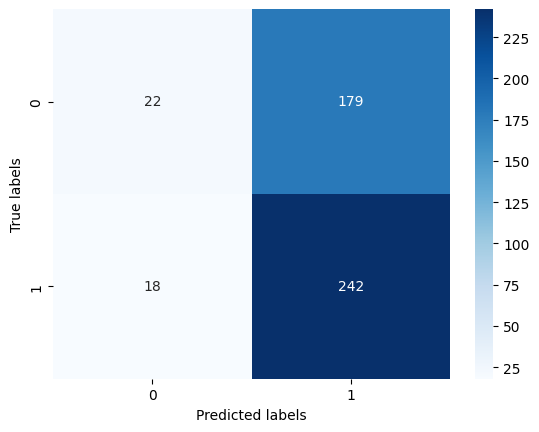

Confusion Matrix: 
None



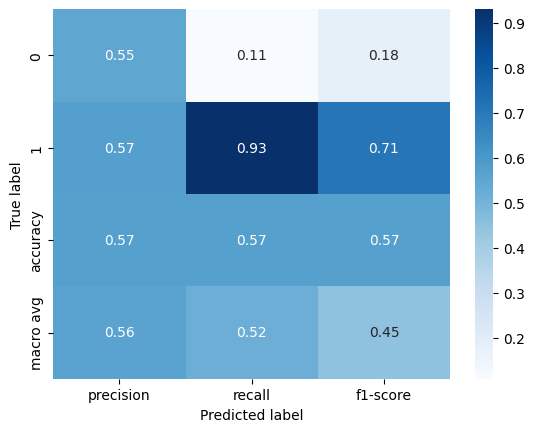

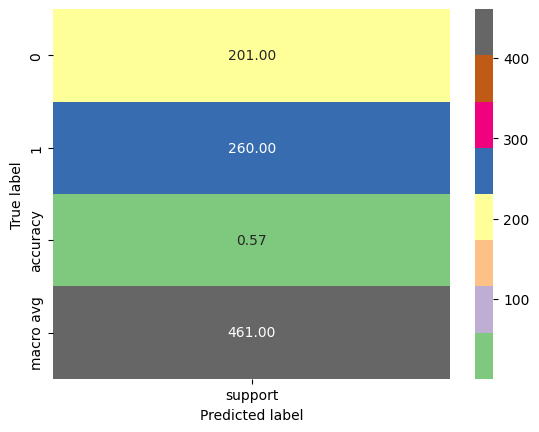

Classification Report: 
None

--- XGBoost for Tomorrow Close ---
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 200, 'subsample': 0.9}
Accuracy: 0.5379609544468547
Precision: 0.548951048951049
Recall: 0.6514522821576764
F1 Score: 0.5958254269449715
ROC AUC: 0.53254432289702


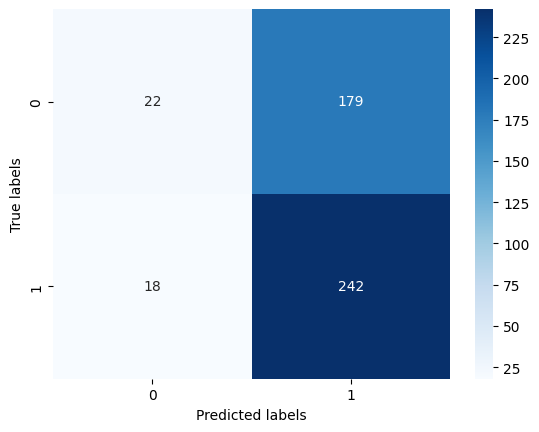

Confusion Matrix: 
None



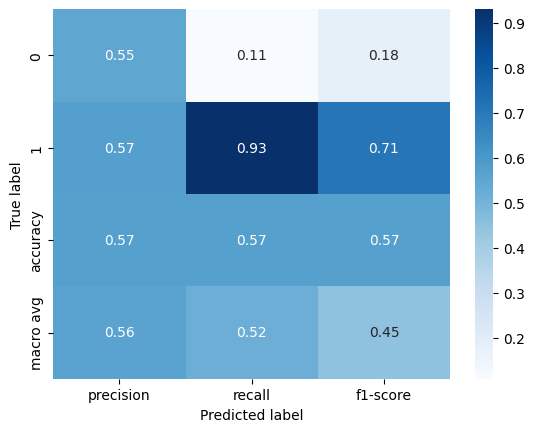

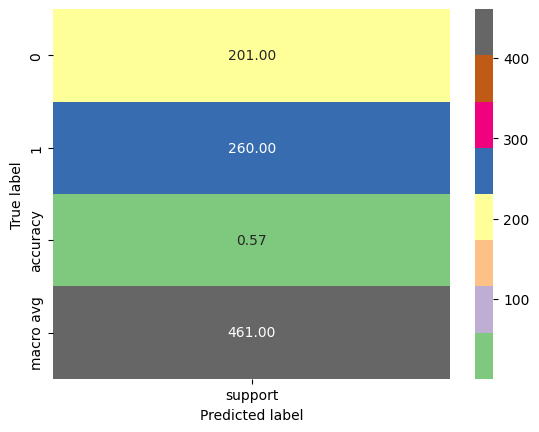

Classification Report: 
None

Prediction for 2024-08-13:
Prediction open : 1
Prediction close : 0
Price will go down.


In [17]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV

# Split the data into training and testing sets for standardized data
X_train_std_open, X_test_std_open, y_train_std_open, y_test_std_open = train_test_split(X_standardized, y_open, test_size=0.2, random_state=4)
X_train_std_close, X_test_std_close, y_train_std_close, y_test_std_close = train_test_split(X_standardized, y_close, test_size=0.2, random_state=4)

# Define parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Train and evaluate XGBoost for 'Tomorrow Open'
xgb_clf_open = xgb.XGBClassifier(random_state=42)
grid_search_xgb_open = GridSearchCV(xgb_clf_open, param_grid_xgb, cv=5, scoring='accuracy')
grid_search_xgb_open.fit(X_train_std_open, y_train_std_open)
best_xgb_open = grid_search_xgb_open.best_estimator_
y_pred_open = best_xgb_open.predict(X_test_std_open)

print(f'--- XGBoost for Tomorrow Open ---')
print(f'Best Parameters: {grid_search_xgb_open.best_params_}')
print(f'Accuracy: {accuracy_score(y_test_std_open, y_pred_open)}')
print(f'Precision: {precision_score(y_test_std_open, y_pred_open)}')
print(f'Recall: {recall_score(y_test_std_open, y_pred_open)}')
print(f'F1 Score: {f1_score(y_test_std_open, y_pred_open)}')
print(f'ROC AUC: {roc_auc_score(y_test_std_open, y_pred_open)}')
print(f'Confusion Matrix: \n{confusion_matrixtask(y_test_std_open, y_pred_open)}\n')
print(f'Classification Report: \n{classification_reportTask(y_test_std_open, y_pred_open)}\n')


# Train and evaluate XGBoost for 'Tomorrow Close'
xgb_clf_close = xgb.XGBClassifier(random_state=42)
grid_search_xgb_close = GridSearchCV(xgb_clf_close, param_grid_xgb, cv=5, scoring='accuracy')
grid_search_xgb_close.fit(X_train_std_close, y_train_std_close)
best_xgb_close = grid_search_xgb_close.best_estimator_
y_pred_close = best_xgb_close.predict(X_test_std_close)

print(f'--- XGBoost for Tomorrow Close ---')
print(f'Best Parameters: {grid_search_xgb_close.best_params_}')
print(f'Accuracy: {accuracy_score(y_test_std_close, y_pred_close)}')
print(f'Precision: {precision_score(y_test_std_close, y_pred_close)}')
print(f'Recall: {recall_score(y_test_std_close, y_pred_close)}')
print(f'F1 Score: {f1_score(y_test_std_close, y_pred_close)}')
print(f'ROC AUC: {roc_auc_score(y_test_std_close, y_pred_close)}')
print(f'Confusion Matrix: \n{confusion_matrixtask(y_test_std_open, y_pred_open)}\n')
print(f'Classification Report: \n{classification_reportTask(y_test_std_open, y_pred_open)}\n')

# Predict the price direction for a new sample using the best XGBoost model
price_direction_open = best_xgb_open.predict(new_sample_standardized)[0]
price_direction_close = best_xgb_close.predict(new_sample_standardized)[0]

# Print the prediction
print(f'Prediction for {prediction_date.date()}:')
print(f'Prediction open : {price_direction_open}')
print(f'Prediction close : {price_direction_close}')

# Print the consolidated result
if price_direction_open == 1 and price_direction_close == 1:
    print("Price will go up.")
elif price_direction_open == 0 and price_direction_close == 1:
    print("Price will go up.")
elif price_direction_open == 1 and price_direction_close == 0:
    print("Price will go down.")
else:
    print("Price will go down.")


Wide and Deep learning model using TensorFlow and Keras

In [18]:
# Split the data into training and testing sets for standardized data
X_train_std_open, X_test_std_open, y_train_std_open, y_test_std_open = train_test_split(X, y_open, test_size=0.2, random_state=4)
X_train_std_close, X_test_std_close, y_train_std_close, y_test_std_close = train_test_split(X, y_close, test_size=0.2, random_state=4)

# Standardize the continuous features
scaler = StandardScaler()
X_train_std_open = scaler.fit_transform(X_train_std_open)
X_test_std_open = scaler.transform(X_test_std_open)
X_train_std_close = scaler.fit_transform(X_train_std_close)
X_test_std_close = scaler.transform(X_test_std_close)

# Define Wide Model
input_wide = Input(shape=(X_train_std_open.shape[1],))
wide_out = Dense(1, activation='sigmoid')(input_wide)

# Define Deep Model
input_deep = Input(shape=(X_train_std_open.shape[1],))
x = Dense(128, activation='relu')(input_deep)
x = Dense(64, activation='relu')(x)
deep_out = Dense(1, activation='sigmoid')(x)

# Combine Wide and Deep Models
combined = Concatenate()([wide_out, deep_out])
output = Dense(1, activation='sigmoid')(combined)

# Create and compile the model
model = Model(inputs=[input_wide, input_deep], outputs=output)
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model for 'Tomorrow Open'
history_open = model.fit([X_train_std_open, X_train_std_open], y_train_std_open, epochs=20, batch_size=32, validation_data=([X_test_std_open, X_test_std_open], y_test_std_open))

# Evaluate the model for 'Tomorrow Open'
loss_open, accuracy_open = model.evaluate([X_test_std_open, X_test_std_open], y_test_std_open)
print(f'Accuracy for Tomorrow Open: {accuracy_open * 100:.2f}%')

# Train the model for 'Tomorrow Close'
history_close = model.fit([X_train_std_close, X_train_std_close], y_train_std_close, epochs=20, batch_size=32, validation_data=([X_test_std_close, X_test_std_close], y_test_std_close))

# Evaluate the model for 'Tomorrow Close'
loss_close, accuracy_close = model.evaluate([X_test_std_close, X_test_std_close], y_test_std_close)
print(f'Accuracy for Tomorrow Close: {accuracy_close * 100:.2f}%')

# Use the last row of the data to predict the next day's price direction
last_row = historical_data.iloc[-1].drop(['Tomorrow Open', 'Tomorrow Close', 'Price Direction Open', 'Price Direction Close'])
last_row = last_row.to_frame().T  # Convert to DataFrame
last_row_standardized = scaler.transform(last_row)

price_direction_open = model.predict([last_row_standardized, last_row_standardized])[0][0]
price_direction_close = model.predict([last_row_standardized, last_row_standardized])[0][0]

# Get the date for which the prediction is made
prediction_date = historical_data.index[-1] + pd.Timedelta(days=1)

print(f'Prediction for {prediction_date.date()}:')
print(f'Prediction open : {1 if price_direction_open > 0.5 else 0}')
print(f'Prediction close : {1 if price_direction_close > 0.5 else 0}')

# Print the consolidated result
if price_direction_open > 0.5 and price_direction_close > 0.5:
    print("Price will go up.")
elif price_direction_open <= 0.5 and price_direction_close > 0.5:
    print("Price will go up.")
elif price_direction_open > 0.5 and price_direction_close <= 0.5:
    print("Price will go down.")
else:
    print("Price will go down.")


Epoch 1/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.4345 - loss: 0.7469 - val_accuracy: 0.4360 - val_loss: 0.7228
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4438 - loss: 0.7171 - val_accuracy: 0.4360 - val_loss: 0.7128
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4412 - loss: 0.7090 - val_accuracy: 0.4360 - val_loss: 0.7052
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4469 - loss: 0.7023 - val_accuracy: 0.4382 - val_loss: 0.6993
Epoch 5/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4540 - loss: 0.6991 - val_accuracy: 0.4685 - val_loss: 0.6950
Epoch 6/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4986 - loss: 0.6944 - val_accuracy: 0.5249 - val_loss: 0.6915
Epoch 7/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5168 - loss: 0.6928 - val_accuracy: 0.5770 - val_loss: 0.6892
Epoch 8/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5297 - loss: 0.6900 - val_accuracy: 0.5640 - val_loss